In [0]:
import pickle
import pylab
import numpy as np
import csv
import pandas as pd
import time as time
import scipy.ndimage as img
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1KrCyB8w_Su3H7RA1NokEtqZ_LjZ2EHob'})
downloaded.GetContentFile('train_max_x')    

train_images = pd.read_pickle('train_max_x') 

# downloaded = drive.CreateFile({'id':'1n02LQULkmKrrzHdILoYBIa_182LlHAWs'}) 
# downloaded.GetContentFile('test_max_x')    

# test_images = pd.read_pickle('test_max_x')

downloaded = drive.CreateFile({'id':'1CBnAaigf04_6GjMQCUbLcUCMW3Hb0mZg'})   
downloaded.GetContentFile('train_max_y.csv')    

train_y = pd.read_csv('train_max_y.csv')

In [5]:
import cv2
trainYnp = train_y.T.iloc[-1].to_numpy()
for i in range(50000):
  if trainYnp[i] == 0:
    trainYnp = np.append(trainYnp, 0)
    train_images = np.append(train_images,[cv2.flip(train_images[i], 1)], axis=0)
    trainYnp = np.append(trainYnp, 0)
    train_images = np.append(train_images,[cv2.flip(train_images[i], 0)], axis=0)
    trainYnp = np.append(trainYnp, 0)
    train_images = np.append(train_images,[cv2.flip(train_images[i], -1)], axis=0)
  elif trainYnp[i] == 1:
    trainYnp = np.append(trainYnp, 1)
    train_images = np.append(train_images,[cv2.flip(train_images[i], 1)], axis=0)

print(train_images.shape)
print(trainYnp.shape)
pred = pd.DataFrame(trainYnp, columns=['Label'])
pred.to_csv('predResult.csv', index=True, index_label='Id', header=True)
fileName = 'train_real_y.csv'
uploaded = drive.CreateFile({'title': fileName})
uploaded.SetContentFile('predResult.csv')
uploaded.Upload()

(50547, 128, 128)
(50547,)


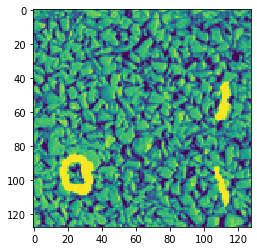

In [7]:
pylab.imshow(train_images[50457])

In [8]:
oneDTrainImg = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
#oneDTestImg = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1)
train_images = 0
print(oneDTrainImg.shape)

(50547, 128, 128, 1)


In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
#trainYnp = train_y.T.iloc[-1].to_numpy()
#onehotY = keras.utils.to_categorical(trainYnp)

In [0]:
#Do NOT Run This Block
model0 = Sequential()
model0.add(Dense(500,input_shape=(16384,)))  # 输入层， 28*28=784
model0.add(Activation('tanh'))
model0.add(Dropout(0.3))   # 30% dropout
model0.add(Dense(300))  # 隐藏层， 300
model0.add(Activation('tanh'))
model0.add(Dropout(0.3))   # 30% dropout
model0.add(Dense(10))
model0.add(Activation('softmax'))

# 编译模型
sgd0 = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)   
model0.compile(loss = 'categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model0.fit(oneDTrainImg, onehotY, batch_size=50, epochs=60, verbose=1, validation_split=0.3)

In [0]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model1.add(BatchNormalization())
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.3))
model1.add(BatchNormalization())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.3))
model1.add(BatchNormalization())
model1.add(Dense(10, activation='softmax'))

model1.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

model1.fit(oneDTrainImg, onehotY, batch_size=256, epochs=20, verbose=1, validation_split=0.05)

Train on 47500 samples, validate on 2500 samples
Epoch 1/20
47500/47500 [==============================] - 145s 3ms/step - loss: 2.2586 - acc: 0.2078 - val_loss: 2.0128 - val_acc: 0.2356
Epoch 2/20
47500/47500 [==============================] - 135s 3ms/step - loss: 1.9619 - acc: 0.2677 - val_loss: 2.0430 - val_acc: 0.2404
Epoch 3/20
47500/47500 [==============================] - 135s 3ms/step - loss: 1.5900 - acc: 0.4103 - val_loss: 1.9646 - val_acc: 0.2880
Epoch 4/20
47500/47500 [==============================] - 135s 3ms/step - loss: 0.9612 - acc: 0.6692 - val_loss: 2.4420 - val_acc: 0.2788
Epoch 5/20
47500/47500 [==============================] - 134s 3ms/step - loss: 0.5625 - acc: 0.8120 - val_loss: 1.0951 - val_acc: 0.7200
Epoch 6/20
47500/47500 [==============================] - 134s 3ms/step - loss: 0.3594 - acc: 0.8851 - val_loss: 0.3900 - val_acc: 0.8692
Epoch 7/20
47500/47500 [==============================] - 134s 3ms/step - loss: 0.2574 - acc: 0.9181 - val_loss: 0.9217 - v

In [0]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(10, activation='softmax'))

model2.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

#model2.fit(oneDTrainImg, onehotY, batch_size=256, epochs=20, verbose=1, validation_split=0.05)
plot_model(model2, to_file='model.png', show_shapes=True, show_layer_names=True)
uploaded = drive.CreateFile({'title': 'abc1.png'})
uploaded.SetContentFile('model.png')
uploaded.Upload() 

[[[ 50.  50.  50.]
  [ 51.  51.  51.]
  [ 50.  50.  50.]
  ...
  [ 50.  50.  50.]
  [ 51.  51.  51.]
  [ 53.  53.  53.]]

 [[ 50.  50.  50.]
  [ 47.  47.  47.]
  [ 50.  50.  50.]
  ...
  [ 50.  50.  50.]
  [ 47.  47.  47.]
  [ 49.  49.  49.]]

 [[ 44.  44.  44.]
  [ 48.  48.  48.]
  [ 49.  49.  49.]
  ...
  [ 62.  62.  62.]
  [ 54.  54.  54.]
  [ 46.  46.  46.]]

 ...

 [[ 53.  53.  53.]
  [ 45.  45.  45.]
  [ 57.  57.  57.]
  ...
  [ 36.  36.  36.]
  [ 41.  41.  41.]
  [ 36.  36.  36.]]

 [[ 50.  50.  50.]
  [ 58.  58.  58.]
  [ 54.  54.  54.]
  ...
  [ 38.  38.  38.]
  [ 42.  42.  42.]
  [ 35.  35.  35.]]

 [[ 63.  63.  63.]
  [124. 124. 124.]
  [ 80.  80.  80.]
  ...
  [ 42.  42.  42.]
  [ 38.  38.  38.]
  [ 46.  46.  46.]]]


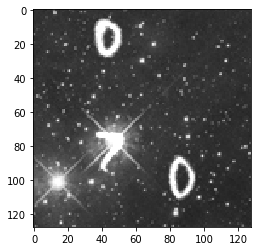

In [0]:
# import matplotlib.image as mpimg 
# from matplotlib.pyplot import imshow
# %matplotlib inline
# # testImg = np.zeros((5000, 128, 128, 3))
# # for i in range(testImg.shape[0]):
# #   for j in range(oneDTrainImg.shape[1]):
# #     for k in range(oneDTrainImg.shape[2]):
# #       testImg[i][j][k][0] = oneDTrainImg[i][j][k][0]
# #       testImg[i][j][k][1] = oneDTrainImg[i][j][k][0]
# #       testImg[i][j][k][2] = oneDTrainImg[i][j][k][0]
# testImg = oneDTrainImg[:50000].repeat(3,axis=3)
# print(testImg[1])
# testImg = testImg/255

# imshow(testImg[1])

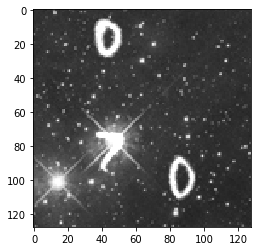

In [0]:
# testImg = testImg / 255
# imshow(testImg[1])

(2, 64, 64, 3)
[[[0.19215686 0.19215686 0.19215686]
  [0.19607843 0.19607843 0.19607843]
  [0.19215686 0.19215686 0.19215686]
  ...
  [0.21568627 0.21568627 0.21568627]
  [0.19607843 0.19607843 0.19607843]
  [0.19607843 0.19607843 0.19607843]]

 [[0.18431373 0.18431373 0.18431373]
  [0.18431373 0.18431373 0.18431373]
  [0.19215686 0.19215686 0.19215686]
  ...
  [0.19607843 0.19607843 0.19607843]
  [0.20784314 0.20784314 0.20784314]
  [0.19607843 0.19607843 0.19607843]]

 [[0.19607843 0.19607843 0.19607843]
  [0.18039216 0.18039216 0.18039216]
  [0.20392157 0.20392157 0.20392157]
  ...
  [0.19607843 0.19607843 0.19607843]
  [0.18431373 0.18431373 0.18431373]
  [0.18823529 0.18823529 0.18823529]]

 ...

 [[0.20784314 0.20784314 0.20784314]
  [0.23921569 0.23921569 0.23921569]
  [0.25490196 0.25490196 0.25490196]
  ...
  [0.15686275 0.15686275 0.15686275]
  [0.15686275 0.15686275 0.15686275]
  [0.15294118 0.15294118 0.15294118]]

 [[0.2        0.2        0.2       ]
  [0.23529412 0.235294

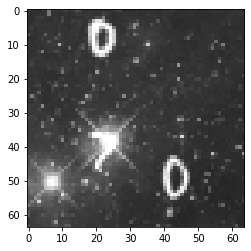

In [0]:
# import cv2
# import matplotlib.image as mpimg 
# from matplotlib.pyplot import imshow
# %matplotlib inline
# X_train = oneDTrainImg[:2]
# X_train = [cv2.cvtColor(cv2.resize(i,(64,64)), cv2.COLOR_GRAY2BGR) for i in X_train]
# X_train = np.concatenate([arr[np.newaxis] for arr in X_train]).astype('int')
# X_train = X_train / 255
# print(X_train.shape)
# print(X_train[1])
# imshow(X_train[1])

In [0]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Model
from keras.optimizers import SGD
def useVgg(X_train, onehotY):
  model_vgg = VGG16(include_top=False, weights=None, input_shape=(128, 128, 3))
  for layer in model_vgg.layers:
      layer.trainable = True
  model = Flatten(name='flatten')(model_vgg.output)
  model = Dense(4096, activation='relu', name='fc1')(model)
  model = Dense(4096, activation='relu', name='fc2')(model)
  model = Dropout(0.25)(model)
  model = Dense(2048, activation='relu', name='fc3')(model)
  model = Dropout(0.20)(model)
  model = Dense(1024, activation='relu', name='fc4')(model)
  model = Dropout(0.15)(model)
  model = Dense(256, activation='relu', name='fc5')(model)
  model = Dropout(0.1)(model)
  model = Dense(10, activation='softmax')(model)
  model_vgg_mnist = Model(inputs=model_vgg.input, outputs=model, name='vgg16')

  model_vgg_mnist.summary()

  #sgd = SGD(lr=0.1, decay=1e-15)

  model_vgg_mnist.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
  model_vgg_mnist.fit(X_train, onehotY, validation_split=0.2, epochs=100, batch_size=32)

In [0]:
from keras.applications.resnet_v2 import ResNet50V2
from keras.layers import Input
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Model
from keras.optimizers import SGD
def useResNet(X_train, onehotY):
  model_res = ResNet50V2(include_top=False, weights=None, input_shape=(128, 128, 3))
  # for layer in model_res.layers:
  #     layer.trainable = False
  x = GlobalAveragePooling2D()(model_res.output)
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(2048, activation='relu')(x)
  x = Dropout(0.25)(x)
  # model = Dense(1024, activation='relu')(model)
  # model = Dropout(0.15)(model)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.25)(x)
  predictions = Dense(10, activation='softmax')(x)
  model = Model(inputs=model_res.input, outputs=predictions)
  model.summary()

  sgd = SGD(lr=0.1, decay=3e-5)

  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

  model.fit(X_train, onehotY, validation_split=0.01, epochs=30, batch_size=32)

  model.save('modelres0.h5')    
  model_file = drive.CreateFile({'title' : 'modelres0.h5'})
  model_file.SetContentFile('modelres0.h5')
  model_file.Upload()

  # download to google drive
  drive.CreateFile({'id': model_file.get('id')})
  # for i = range(1, 4):
    
  #   model.fit(X_train, onehotY, validation_split=0.01, epochs=5, batch_size=32)

  #   model.save('modelres'+i+'.h5')    
  #   model_file = drive.CreateFile({'title' : 'modelres'+i+'.h5'})
  #   model_file.SetContentFile('modelres'+i+'.h5')
  #   model_file.Upload()

  #   # download to google drive
  #   drive.CreateFile({'id': model_file.get('id')})

In [0]:
from keras.applications.xception import Xception
from keras.layers import Input
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import time
import math
from keras.utils import plot_model
def useXception(X_train, onehotY):
  model_res = Xception(include_top=False, weights=None, input_shape=(128, 128, 3))
  # for layer in model_res.layers:
  #     layer.trainable = False
  x = GlobalAveragePooling2D()(model_res.output)
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(2048, activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.25)(x)
  predictions = Dense(10, activation='softmax')(x)
  model = Model(inputs=model_res.input, outputs=predictions)
  model.summary()

  sgd = SGD(lr=0.1, decay=0, momentum=0.8, nesterov=True)

  def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.667
    epochs_drop = 1
    if epoch > 8:
      epochs_drop = math.pow(drop, (epoch-8))
    lrate = initial_lrate * epochs_drop
    return lrate

  lrate = LearningRateScheduler(step_decay)

  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

  #model.fit(X_train, onehotY, validation_split=0.01, epochs=30, batch_size=32, callbacks=[lrate])
  plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
  uploaded = drive.CreateFile({'title': 'abc.png'})
  uploaded.SetContentFile('model.png')
  uploaded.Upload() 


Using TensorFlow backend.


In [0]:
X_train = oneDTrainImg.repeat(3,axis=3)
X_train = X_train / 255
np.save('modImg.npy', X_train)
uploaded = drive.CreateFile({'title': 'modImg.npy'})
uploaded.SetContentFile('modImg.npy')
uploaded.Upload()
oneDTrainImg = 0
# X_test = oneDTestImg.repeat(3,axis=3)
# X_test = X_test / 255
# oneDTestImg = 0

In [0]:
from keras.applications.nasnet import NASNetLarge
from keras.layers import Input
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Model
from keras.optimizers import SGD
import matplotlib.pyplot as plt
def useNas(X_train, onehotY):
  model_res = NASNetLarge(include_top=False, weights=None, input_shape=(128, 128, 3))
  # for layer in model_res.layers:
  #     layer.trainable = False
  x = GlobalAveragePooling2D()(model_res.output)
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(2048, activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.15)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.25)(x)
  predictions = Dense(10, activation='softmax')(x)
  model = Model(inputs=model_res.input, outputs=predictions)
  model.summary()

  sgd = SGD(lr=0.5, decay=3e-5)

  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(X_train, onehotY, validation_split=0.01, epochs=50, batch_size=32)

  plt.plot(history.history['loss'])

  plt.plot(history.history['val_loss'])

  plt.title("model loss")

  plt.ylabel("loss")

  plt.xlabel("epoch")

  plt.legend(["train","test"],loc="upper left")

  plt.show()

In [0]:
X_train = 0
onehotY = 0
useXception(X_train, onehotY)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________